In [1]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from collections import OrderedDict
from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_dataset, generate_dataset_from_loader,preprocess_dataset_get_data_loader,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
import numpy as np
import csv
from conv4_models import get_model_instance_from_dataset, get_img_size
from utils.forward_visualization_helpers import merge_operations_in_modules, apply_input_on_conv_matrix, merge_layers_operations_in_modules
from sklearn import datasets, metrics, svm
from tqdm import trange
import pickle
from structure.generic_structure import SaveFeatures
from matplotlib import colors
from sklearn.decomposition import PCA
from adversarial_attacks_tester import apply_adversarial_attack_on_input

Using TensorFlow backend.
2024-09-26 00:18:56.574675: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-09-26 00:18:56.574836: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-09-26 00:18:56.574847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
adv_attack_type = "PGD"
adv_target = None
number_of_adversarial_optimization_steps = 40
eps = 0.3
eps_step_size = 0.01
update_on='all'
rand_init=True
norm=np.inf
use_ytrue=True
number_of_restarts = 1
residue_vname = None
is_targetted=False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_arch_type = 'dnn'
dataset = 'fashion_mnist'
data_config = DatasetConfig(
                dataset, is_normalize_data=True, valid_split_size=0.1, batch_size=256, list_of_classes=None,custom_dataset_path=None)

filtered_X_train, filtered_y_train, _, _, filtered_X_test, filtered_y_test = preprocess_dataset_get_dataset(
            data_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)
print("filtered_X_train ",np.max(filtered_X_train),np.min(filtered_X_train))
print("filtered_X_test ",np.max(filtered_X_test),np.min(filtered_X_test))
trainloader = get_data_loader(
    filtered_X_train, filtered_y_train, data_config.batch_size, transforms=data_config.train_transforms)
testloader = get_data_loader(
    filtered_X_test, filtered_y_test, data_config.batch_size, transforms=data_config.test_transforms)

# trainloader, _, testloader = preprocess_dataset_get_data_loader(
#                 data_config, model_arch_type, verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

np.max(filtered_X_train) 255.0
filtered_X_train  1.0 0.0
filtered_X_test  1.0 0.0


In [5]:
tst = next(iter(trainloader))
tst[0].size()

torch.Size([256, 1, 28, 28])

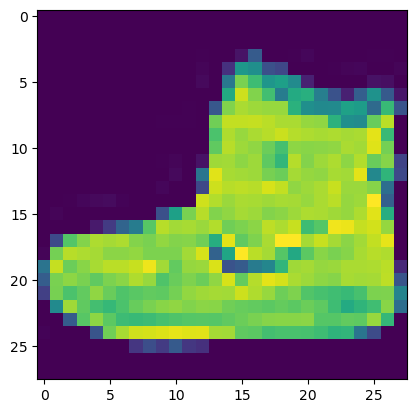

In [6]:
img = tst[0][0]
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [7]:
def get_misclassified_sample_indices(model_arch_type,mpath,trainloader,fc_width=128,fc_depth = 4,pca_exp_percent=None):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    acc = 0.
    incorr_ind_list=[]
    corr_ind_list=[]
    
    loader = tqdm.tqdm(trainloader, desc='Adversarial Evaluating')
    for batch_idx, data in enumerate(loader, 0):
        (images, labels) = data
        images, labels = images.to(
            device), labels.to(device)
        
        adv_images = apply_adversarial_attack_on_input(images, model, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, labels, is_targetted,update_on,rand_init,norm,use_ytrue,residue_vname=residue_vname)

        outputs = model(adv_images)
        
        if(len(outputs.size())==1):
            predicted = torch.sigmoid(outputs.data).round()
        else:
            _, predicted = torch.max(outputs.data, 1)
        eq = (predicted == labels)
        incorr_indices = (eq == False).nonzero().view(-1)+total
        incorr_ind_list.extend(incorr_indices.cpu())
        corr_indices = (eq == True).nonzero().view(-1)+total
        corr_ind_list.extend(corr_indices.cpu())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100.*correct/total
    print("acc ",acc)

    return  incorr_ind_list,corr_ind_list
        

In [8]:
def get_margin_change_accuracy(model_arch_type,mpath,trainloader,fc_width=128,fc_depth = 4,pca_exp_percent=None):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    if(pca_exp_percent is not None):
        dataset_for_pca = generate_dataset_from_loader(trainloader)
        if(isinstance(dataset_for_pca.list_of_x[0], torch.Tensor)):
            dataset_for_pca = torch.stack(
                dataset_for_pca.list_of_x), torch.stack(dataset_for_pca.list_of_y)
        else:
            dataset_for_pca = np.array(dataset_for_pca.list_of_x), np.array(
                dataset_for_pca.list_of_y)
        number_of_components_for_pca = model.initialize_PCA_transformation(
            dataset_for_pca[0], pca_exp_percent)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()
    correct = 0
    correct_with_changed_beta = 0
    total = 0
    mod_beta = 10
    real_beta = model.beta
    
    loader = tqdm.tqdm(trainloader, desc='Margin change evaluation')
    for batch_idx, data in enumerate(loader, 0):
        (images, labels) = data
        images, labels = images.to(
            device), labels.to(device)
        
        outputs = model(images)

        if(len(outputs.size())==1):
            predicted = torch.sigmoid(outputs.data).round()
        else:
            _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        model.beta = mod_beta
        outputs = model(images)
        model.beta = real_beta
        
        if(len(outputs.size())==1):
            predicted = torch.sigmoid(outputs.data).round()
        else:
            _, predicted = torch.max(outputs.data, 1)
        correct_with_changed_beta += (predicted == labels).sum().item()
    
    acc = 100.*correct/total
    acc_changed_beta = 100.*correct_with_changed_beta/total
    print("Accuracy on original examples with original model beta=4: {} and with modified beta={}: {}".format(acc,mod_beta,acc_changed_beta))
    
    return acc

In [9]:
def get_margin_folder(model_path):
    return model_path.replace(".pt","/MARGIN_ANALYSIS/")

In [10]:
def generate_effective_convs(model,is_include_pca=False,dummy_input=None):
    model.eval()
    if(dummy_input is None):
        dummy_input = torch.rand(get_img_size(dataset)).unsqueeze(0)

    dummy_input = dummy_input.to(device)
    print("dummy_input ",dummy_input.size())
    conv_matrix_operations_in_each_layer, conv_bias_operations_in_each_layer, channel_outs_size_in_each_layer = model.exact_forward_vis(dummy_input,is_include_pca)

    return conv_matrix_operations_in_each_layer,conv_bias_operations_in_each_layer,channel_outs_size_in_each_layer

In [11]:
pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
# std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt"
std_path = "root/model/save/mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_PCA_K155_P_0.95_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/OPT_Adam (Parameter Group 0    amsgrad: False    betas: (0.9, 0.999)    eps: 1e-08    lr: 0.0001    weight_decay: 0)/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/out_lossfn_CrossEntropyLoss()/inner_lossfn_CrossEntropyLoss()/adv_model_dir.pt"

In [12]:
get_margin_change_accuracy("fc_dlgn",pgdat_path,trainloader)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306


Margin change evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Margin change evaluation: 100%|██████████| 235/235 [00:07<00:00, 33.48it/s]

Accuracy on original examples with original model beta=4: 65.94 and with modified beta=10: 65.91833333333334


65.94

In [17]:
get_margin_change_accuracy("fc_dlgn",std_path,trainloader,pca_exp_percent=0.95)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306


Generating dataset from loader: 100%|██████████| 235/235 [00:01<00:00, 197.84it/s]


Number of PCA components used is: 155
self.gating_network Gating network  
 module_list:Linear(in_features=155, out_features=128, bias=True) 
 Params in module is:19968
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 69504
self.value_network Value network  
 module_list:Linear(in_features=155, out_features=128, bias=True) 
 Params in module is:19968
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 70794


Margin change evaluation: 100%|██████████| 235/235 [00:01<00:00, 141.79it/s]

Accuracy on original examples with original model beta=4: 89.82833333333333 and with modified beta=10: 90.82833333333333


89.82833333333333

In [ ]:
incorr_ind_pgdat,corr_ind_pgdat = get_misclassified_sample_indices("fc_dlgn",pgdat_path,trainloader)
len(incorr_ind_pgdat),len(corr_ind_pgdat)

In [ ]:

incorr_ind_std,corr_ind_std = get_misclassified_sample_indices("fc_dlgn",std_path,trainloader)
len(incorr_ind_std),len(corr_ind_std)

In [55]:
filtered_X_train_tensor,filtered_y_train_tensor = torch.tensor(filtered_X_train),torch.tensor(filtered_y_train)
filtered_X_train_tensor.size(),filtered_y_train_tensor.size()

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [56]:
corr_Xtrain_pgdat,corr_ytrain_pgdat = filtered_X_train_tensor[[corr_ind_pgdat[:10]]],filtered_y_train_tensor[[corr_ind_pgdat[:10]]]
corr_Xtrain_pgdat.size(),corr_ytrain_pgdat.size()

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

In [11]:
def get_batch_margin(model,conv_matrix_operations_in_each_layer,outcapturer):
    cur_batch_margins = None
    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        cur_w = conv_matrix_operations_in_each_layer[key]
        cur_eff_w_norm = torch.norm(cur_w,p=2,dim=1).unsqueeze(0).to(device=outcapturer[key].features.device)
        cur_margin = torch.flatten(outcapturer[key].features,1)/cur_eff_w_norm
        if(cur_batch_margins is None):
            cur_batch_margins = cur_margin.T
        else:
            cur_batch_margins = torch.vstack([cur_batch_margins,cur_margin.T])

    return cur_batch_margins

In [12]:
def get_flip_dist_hyperplanes_per_model(model,trainloader,number_of_components_for_pca=None):
    outcapturer = OrderedDict()
    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        if isinstance(cur_m, nn.Linear) or isinstance(cur_m, nn.Conv2d):
            print(key,cur_m.weight.size(),cur_m.bias.size(),cur_m.weight.dtype,cur_m.bias.dtype)
            outcapturer[key] = SaveFeatures(cur_m)

    dummy_input = None
    if(number_of_components_for_pca is not None):
        dummy_input = torch.rand((1,number_of_components_for_pca)).unsqueeze(0)
    eff_weights,eff_bias,chouts = generate_effective_convs(model,dummy_input)


    res=None
    loader = tqdm.tqdm(trainloader, desc='Generating Distance from HP')
    for batch_idx, data in enumerate(loader, 0):
        (X, y) = data
        X, y = X.to(device), y.to(device)
        
        adv_img = apply_adversarial_attack_on_input(X, model, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, y, is_targetted,update_on,rand_init,norm,use_ytrue,residue_vname=residue_vname)

        model(X)
        dist_hp_org = torch.sign(get_batch_margin(model,eff_weights,outcapturer))

        model(adv_img)
        dist_hp_adv = torch.sign(get_batch_margin(model,eff_weights,outcapturer))
        tmp = dist_hp_org * dist_hp_adv
        o=torch.ones(1).to(device=tmp.device)
        z=torch.zeros(1).to(device=tmp.device)
        tmp=torch.where(tmp<0,o,z)
        tmp = torch.sum(tmp,dim=-1)
        if(res is None):
            res = tmp
        else:
            res += tmp

    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        if isinstance(cur_m, nn.Linear) or isinstance(cur_m, nn.Conv2d):
            outcapturer[key].close()
    
    return res
        

In [13]:
def get_flip_dist_hyperplanes(model_arch_type,trainloader,std_path,pgd_path,fc_width=128,fc_depth = 4):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    std_model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    std_model.load_state_dict(torch.load(std_path).state_dict())
    std_model = std_model.to(device)

    pgdat_model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    pgdat_model.load_state_dict(torch.load(pgd_path).state_dict())
    pgdat_model = pgdat_model.to(device)

    flip_dist_pgdat = get_flip_dist_hyperplanes_per_model(pgdat_model,trainloader)
    print(flip_dist_pgdat.shape)
    flip_dist_stdtr = get_flip_dist_hyperplanes_per_model(std_model,trainloader)
    
    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    fig, axs = plt.subplots(2,1,figsize=(100, 100))
    
    xs = np.arange(flip_dist_pgdat.shape[0])

    axs[0].bar(xs, flip_dist_pgdat.detach().cpu().numpy())
    axs[0].set_title('Flip Distribution of PGD-AT HPs',fontsize=35)
    axs[1].set_ylabel("Frequency",fontsize=35)
    axs[0].set_xlabel("Hyperplane Index",fontsize=35)
    axs[0].set_xticks(list(np.arange(0,flip_dist_pgdat.shape[0],10)),fontsize=35)

    axs[1].bar(xs, flip_dist_stdtr.detach().cpu().numpy())
    axs[1].set_title('Flip Distribution of STD-TR HPs',fontsize=35)
    axs[1].set_ylabel("Frequency",fontsize=35)
    axs[1].set_xlabel("Hyperplane Index",fontsize=35)
    axs[1].set_xticks(list(np.arange(0,flip_dist_stdtr.shape[0],10)),fontsize=35)

    plt.savefig(save_folder+"/hyperplane_flip_distribution.jpg")
    plt.savefig(save_folder+"/hyperplane_flip_distribution.pdf")

    rows =[[a.item(),b.item()] for a,b in zip(flip_dist_pgdat,flip_dist_stdtr)]
    with open(save_folder+"/hyperplane_flip_distribution.csv", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows([["PGD-AT flip-dist","STD-TR flip-dist"]])
        writer.writerows(rows)

    plt.show()

In [14]:
# pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
pgdat_path = "root/model/save/fashion_mnist/adversarial_training/MT_fc_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/OPT_Adam (Parameter Group 0    amsgrad: False    betas: (0.9, 0.999)    eps: 1e-08    lr: 0.0001    weight_decay: 0)/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/out_lossfn_CrossEntropyLoss()/inner_lossfn_CrossEntropyLoss()/adv_model_dir.pt"
# std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt"
std_path = "root/model/save/fashion_mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt"
get_flip_dist_hyperplanes("fc_dlgn",trainloader,std_path,pgdat_path)

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Gating net params: 150016
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in mo

Generating Distance from HP: 100%|██████████| 235/235 [01:28<00:00,  2.65it/s]


torch.Size([512])
fc0_g torch.Size([128, 784]) torch.Size([128]) torch.float32 torch.float32
fc1_g torch.Size([128, 128]) torch.Size([128]) torch.float32 torch.float32
fc2_g torch.Size([128, 128]) torch.Size([128]) torch.float32 torch.float32
fc3_g torch.Size([128, 128]) torch.Size([128]) torch.float32 torch.float32
dummy_input  torch.Size([1, 1, 28, 28])
current_tensor_size  torch.Size([1, 784])
current_layer Linear(in_features=784, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_conv_bias:torch.Size([128]) current_tensor_size:(128,)
difference_in_output  tensor(0., device='cuda:0')
current_layer Linear(in_features=128, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_conv_bias:torch.Size([128]) current_tensor_size:(128,)
difference_in_output  tensor(4.3891e-05, device='cuda:0')
current_layer Linear(in_features=128, out_features=128, bias=True)
merged_conv_matrix:torch.Size([128, 784]) merged_conv_bias:torch.Size([128]) curren

Generating Distance from HP: 100%|██████████| 235/235 [01:28<00:00,  2.66it/s]


In [15]:
def get_per_sample_dist_info(model,sample_ind):
    X,y = filtered_X_train_tensor[sample_ind].unsqueeze(0).to(device),filtered_y_train_tensor[sample_ind].unsqueeze(0).to(device)
    print(X.size(),y.size())
    org_pred = torch.max(model(X).data, 1)[1].item()
    adv_img = apply_adversarial_attack_on_input(X, model, eps, adv_attack_type, number_of_adversarial_optimization_steps, eps_step_size, y, is_targetted,update_on,rand_init,norm,use_ytrue,residue_vname=residue_vname)
    adv_pred = torch.max(model(adv_img).data, 1)[1].item()

    eff_weights,eff_bias,chouts = generate_effective_convs(model)

    outcapturer = OrderedDict()
    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        if isinstance(cur_m, nn.Linear) or isinstance(cur_m, nn.Conv2d):
            print(key,cur_m.weight.size(),cur_m.bias.size())
            outcapturer[key] = SaveFeatures(cur_m)

    model(X)
    dist_hp_org = get_batch_margin(model,eff_weights,outcapturer)

    model(adv_img)
    dist_hp_adv = get_batch_margin(model,eff_weights,outcapturer)

    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        if isinstance(cur_m, nn.Linear) or isinstance(cur_m, nn.Conv2d):
            outcapturer[key].close()

    return org_pred,adv_pred,adv_img,adv_img - X,dist_hp_org.squeeze(-1),dist_hp_adv.squeeze(-1)

In [216]:
def plot_sample_wise_hp_dist_std_vs_pgd(model_arch_type,sample_ind,std_path,pgd_path,fc_width=128,fc_depth = 4):
    nodes_in_each_layer_list = [fc_width] * fc_depth
    std_model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    std_model.load_state_dict(torch.load(std_path).state_dict())
    std_model = std_model.to(device)

    pgdat_model = get_model_instance_from_dataset(dataset,model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    pgdat_model.load_state_dict(torch.load(pgd_path).state_dict())
    pgdat_model = pgdat_model.to(device)

    org_label = filtered_y_train_tensor[sample_ind].to(device)
    
    std_org_pred,std_adv_pred,std_adv_img,pert_std,dist_hp_std_org,dist_hp_std_adv = get_per_sample_dist_info(std_model,sample_ind)
    pgdat_org_pred,pgdat_adv_pred,pgdat_adv_img,pert_pgdat,dist_hp_pgdat_org,dist_hp_pgdat_adv = get_per_sample_dist_info(pgdat_model,sample_ind)
    
    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)+"/Sind_{}_c_{}_stdadv_pr_{}_pgdadv_pr_{}".format(sample_ind,org_label,std_adv_pred,pgdat_adv_pred)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    width = 0.5
    hw=0.2
    fig, axs = plt.subplots(2,2,figsize=(50, 50))

    im=axs[0,0].imshow(pert_std[0][0].detach().cpu().numpy(), interpolation='nearest')
    axs[0,0].set_title("Perturbation image:{} on STD-TR".format(sample_ind),fontsize=35)
    plt.colorbar(im, ax=axs[0,0])

    im=axs[0,1].imshow(std_adv_img[0][0].detach().cpu().numpy(), interpolation='nearest')
    axs[0,1].set_title("Adversarial image:{} on STD-TR".format(sample_ind),fontsize=35)
    plt.colorbar(im, ax=axs[0,1])

    im=axs[1,0].imshow(pert_pgdat[0][0].detach().cpu().numpy(), interpolation='nearest')
    axs[1,0].set_title("Perturbation image:{} on PGD-AT".format(sample_ind),fontsize=35)
    plt.colorbar(im, ax=axs[1,0])

    im=axs[1,1].imshow(pgdat_adv_img[0][0].detach().cpu().numpy(), interpolation='nearest')
    axs[1,1].set_title("Adversarial image:{} on PGD-AT".format(sample_ind),fontsize=35)
    plt.colorbar(im, ax=axs[1,1])

    plt.savefig(save_folder+"/images_std_pgdat_ind_{}_c_{}_stdadv_pr_{}_pgdadv_pr_{}.jpg".format(sample_ind,org_label,std_adv_pred,pgdat_adv_pred))
    plt.savefig(save_folder+"/images_std_pgdat_ind_{}_c_{}_stdadv_pr_{}_pgdadv_pr_{}.pdf".format(sample_ind,org_label,std_adv_pred,pgdat_adv_pred))

    rows =[[a.item(),b.item(),c.item(),d.item()] for a,b,c,d in zip(dist_hp_std_org,dist_hp_std_adv,dist_hp_pgdat_org,dist_hp_pgdat_adv)]
    with open(save_folder+"/distance_from_HP_stats_ind_{}_c_{}_stdadv_pr_{}_pgdadv_pr_{}.csv".format(sample_ind,org_label,std_adv_pred,pgdat_adv_pred), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows([["STD-TR org","STD-TR adv","PGD-AT org","PGD-AT adv"]])
        writer.writerows(rows)

    fig, axs = plt.subplots(4,1,figsize=(100, 100))
    
    xs = np.arange(dist_hp_std_org.shape[0])
    
    axs[0].bar(xs, dist_hp_std_org.detach().cpu().numpy())
    axs[0].set_title('Distance from HP STD-TR original image:{}'.format(sample_ind),fontsize=35)
    axs[0].set_xlabel("Hyperplane Index",fontsize=35)
    axs[0].set_xticks(list(np.arange(0,dist_hp_std_org.shape[0],10)),fontsize=35)

    axs[1].bar(xs, dist_hp_std_adv.detach().cpu().numpy())
    axs[1].set_title('Distance from HP STD-TR adversarial image:{}'.format(sample_ind),fontsize=35)
    axs[1].set_xlabel("Hyperplane Index",fontsize=35)
    axs[1].set_xticks(list(np.arange(0,dist_hp_std_org.shape[0],10)),fontsize=35)

    xs = np.arange(dist_hp_std_org.shape[0])

    axs[2].bar(xs, dist_hp_pgdat_org.detach().cpu().numpy())
    axs[2].set_title('Distance from HP PGD-AT original image:{}'.format(sample_ind),fontsize=35)
    axs[2].set_xlabel("Hyperplane Index",fontsize=35)
    axs[2].set_xticks(list(np.arange(0,dist_hp_std_org.shape[0],10)),fontsize=35)

    axs[3].bar(xs, dist_hp_pgdat_adv.detach().cpu().numpy())
    axs[3].set_title('Distance from HP PGD-AT adversarial image:{}'.format(sample_ind),fontsize=35)
    axs[3].set_xlabel("Hyperplane Index",fontsize=35)
    axs[3].set_xticks(list(np.arange(0,dist_hp_std_org.shape[0],10)),fontsize=35)

    print("org_label:{}    std_org_pred:{}    std_adv_pred:{}".format(org_label,std_org_pred,std_adv_pred))
    print("org_label:{}    pgdat_org_pred:{}  pgdat_adv_pred:{}".format(org_label,pgdat_org_pred,pgdat_adv_pred))

    
    plt.savefig(save_folder+"/distance_from_HP_stats_ind_{}_c_{}_stdadv_pr_{}_pgdadv_pr_{}.jpg".format(sample_ind,org_label,std_adv_pred,pgdat_adv_pred))
    plt.savefig(save_folder+"/distance_from_HP_stats_ind_{}_c_{}_stdadv_pr_{}_pgdadv_pr_{}.pdf".format(sample_ind,org_label,std_adv_pred,pgdat_adv_pred))
    print("Stored at ",save_folder)
    # plt.show()

In [212]:
all_class_indices=[None]*10
i=0
cnt=0
while(cnt<10):
    cl = filtered_y_train_tensor[corr_ind_pgdat[i].item()]
    if(all_class_indices[cl] is None):
        all_class_indices[cl]=i
        cnt+=1
    i+=1

In [ ]:
for ind in all_class_indices:
    plot_sample_wise_hp_dist_std_vs_pgd("fc_dlgn",corr_ind_pgdat[ind].item(),std_path,pgdat_path)